## Analyze access color trends using Unpaywall data

In [1]:
import collections

import pandas
import plotnine
import numpy

import utils

In [2]:
access_df = pandas.read_csv(
    'data/02.unpaywall-access.tsv.xz',
    sep='\t',
    #nrows=100_000,
)
access_df = access_df.query("crossref_type in @utils.get_crossref_types()")
access_df['journal_year'] = access_df.journal_date.str.slice(stop=4).astype('float').astype('Int64')
access_df.head(2)

,doi,crossref_type,journal_date,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa,journal_year
0,10.1080/21645515.2017.1330236,journal-article,2017-06-12,1,0,NaN,NaN,0,2017
3,10.1088/0004-6256/135/4/1201,journal-article,2008-03-04,1,1,open (via free pdf),NaN,0,2008


In [3]:
access_df['journal_access_category'] = 'closed'
access_df.loc[access_df.unpaywall_access.astype(bool), 'journal_access_category'] = 'green'
access_df.loc[access_df.journal_access.astype(bool), 'journal_access_category'] = 'hybrid/bronze'
access_df.loc[access_df.journal_fully_oa.astype(bool), 'journal_access_category'] = 'gold'
access_df.head()

,doi,crossref_type,journal_date,unpaywall_access,journal_access,journal_access_evidence,journal_access_license,journal_fully_oa,journal_year,journal_access_category
0,10.1080/21645515.2017.1330236,journal-article,2017-06-12,1,0,NaN,NaN,0,2017,green
3,10.1088/0004-6256/135/4/1201,journal-article,2008-03-04,1,1,open (via free pdf),NaN,0,2008,hybrid/bronze
4,10.1088/0022-3727/48/43/435001,journal-article,2015-09-29,0,0,NaN,NaN,0,2015,closed
5,10.2478/v10172-012-0058-8,journal-article,2012-01-01,1,1,open (via free pdf),NaN,0,2012,hybrid/bronze
6,10.2307/40203576,journal-article,2001-01-01,0,0,NaN,NaN,0,2001,closed


In [4]:
access_df.journal_access_category.value_counts()

closed           70607556
hybrid/bronze    14143545
green             4156883
gold              3325136
Name: journal_access_category, dtype: int64

In [5]:
access_df.crossref_type.value_counts()

journal-article        73453254
book-chapter           11733039
proceedings-article     5406981
reference-entry          789059
report                   582956
standard                 256910
book-part                  6420
book-section               4501
Name: crossref_type, dtype: int64

In [6]:
def summarize(df):
    row = collections.Counter()
    counts = collections.Counter(df.journal_access_category)
    for category in utils.access_categories_colors:
        row[category] = counts[category]
    row['total'] = len(df)
    return pandas.Series(row)

year_df = access_df.groupby('journal_year').apply(summarize).reset_index()
year_df.journal_year = year_df.journal_year.astype(int)
year_df = year_df.query("1950 <= journal_year <= 2018")
year_df.tail(10)

,journal_year,gold,hybrid/bronze,green,closed,total
454,2009,107390,436328,195444,2086751,2825913
455,2010,145073,479806,200990,2304330,3130199
456,2011,176390,544841,205607,2275931,3202769
457,2012,224134,608263,214910,2259071,3306378
458,2013,278671,662716,231482,2432098,3604967
459,2014,334555,713612,237586,2479865,3765618
460,2015,377263,824789,236819,2441398,3880269
461,2016,411700,912739,257340,2556727,4138506
462,2017,441308,939334,232122,2841960,4454724
463,2018,320334,539472,89009,2027480,2976295


In [7]:
year_df.to_csv('data/05.unpaywall-colors-by-year.tsv', sep='\t', index=False)

In [9]:
year_melt_df = year_df.melt(id_vars=['journal_year', 'total'], var_name='access_category', value_name='count')
year_melt_df.access_category = pandas.Categorical(
    year_melt_df.access_category,
    categories=reversed(list(utils.access_categories_colors))
)
year_melt_df.head(2)

,journal_year,total,access_category,count
0,1950,133702,gold,454
1,1951,143813,gold,481


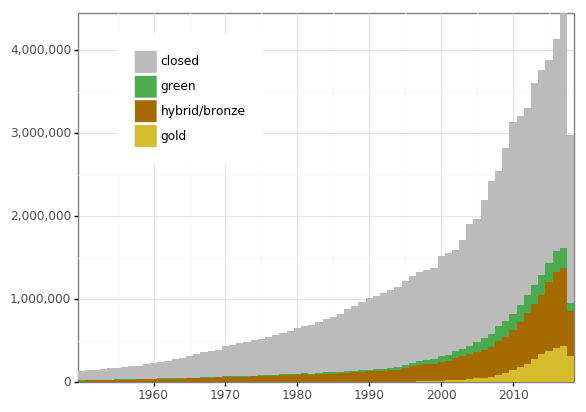

<ggplot: (8777193441337)>

In [10]:
gg_counts = (
    plotnine.ggplot(mapping=plotnine.aes(x='journal_year', y='count', fill='access_category'), data=year_melt_df) +
    plotnine.geom_bar(stat='identity', size=0, color=None, width=1) +
    plotnine.scale_x_continuous(breaks=numpy.arange(1960, 2011, 10), expand=(0, 0), name='') +
    plotnine.scale_y_continuous(labels=lambda array: [f'{x:,.0f}' for x in array], name='', expand=(0,0)) +
    plotnine.scale_fill_manual(values=utils.access_categories_colors) +
    plotnine.theme_bw() +
    plotnine.theme(legend_position=(0.3, 0.7), legend_title=plotnine.element_blank())
)
gg_counts

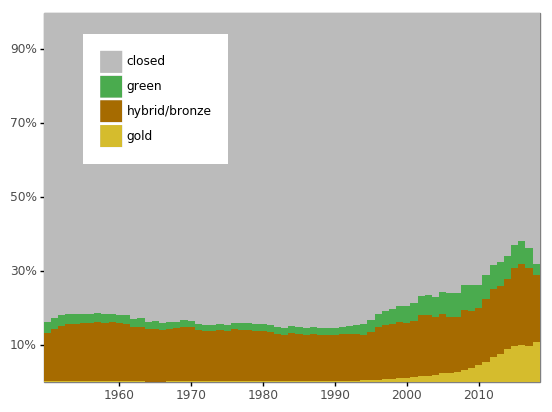

<ggplot: (-9223363259837533871)>

In [12]:
gg_percents = (
    plotnine.ggplot(mapping=plotnine.aes(x='journal_year', y='count', fill='access_category'), data=year_melt_df) +
    plotnine.geom_bar(stat='identity', position='fill', size=0, color=None, width=1) +
    plotnine.scale_fill_manual(values=utils.access_categories_colors) +
    plotnine.scale_x_continuous(breaks=numpy.arange(1960, 2011, 10), expand=(0, 0), name='') +
    plotnine.scale_y_continuous(breaks=numpy.arange(0.1, 1, 0.2), labels=lambda array: [f'{x:.0%}' for x in array], expand=(0, 0), name='') +
    plotnine.theme_bw() +
    plotnine.theme(legend_position=(0.3, 0.7), legend_title=plotnine.element_blank())
)
gg_percents